# Breast Cancer Wisconsin

## I. Chuẩn bị dữ liệu

In [140]:
# Import các thư viện cần thiết
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import config as CONFIG

#### 1. Lấy dữ liệu và xử lí thô

In [141]:
file_path = CONFIG.RAW_DATA_PATH
columns = ['ID', 'Diagnosis'] + [f'Feature_{i}' for i in range(1, 31)]
data = pd.read_csv(file_path, header=None, names=columns)

- Kiểm tra dữ liệu

In [142]:
# Kiểm tra thông tin dữ liệu
print(data.info())

# Kiểm tra sơ bộ
print(data.head())

# Kiểm tra giá trị duy nhất trong nhãn:
print(data['Diagnosis'].value_counts())

# Kiểm tra thống kê dữ liệu:
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          569 non-null    int64  
 1   Diagnosis   569 non-null    object 
 2   Feature_1   569 non-null    float64
 3   Feature_2   569 non-null    float64
 4   Feature_3   569 non-null    float64
 5   Feature_4   569 non-null    float64
 6   Feature_5   569 non-null    float64
 7   Feature_6   569 non-null    float64
 8   Feature_7   569 non-null    float64
 9   Feature_8   569 non-null    float64
 10  Feature_9   569 non-null    float64
 11  Feature_10  569 non-null    float64
 12  Feature_11  569 non-null    float64
 13  Feature_12  569 non-null    float64
 14  Feature_13  569 non-null    float64
 15  Feature_14  569 non-null    float64
 16  Feature_15  569 non-null    float64
 17  Feature_16  569 non-null    float64
 18  Feature_17  569 non-null    float64
 19  Feature_18  569 non-null    f

#### 2. Tiền xử lý dữ liệu

In [143]:
data = data.drop(columns=['ID'])  # Loại bỏ cột ID không cần thiết

- Xáo trộn dữ liệu

In [144]:
rand_value = CONFIG.RANDOM_STATE

data = shuffle(data, random_state=rand_value)

- Tách nhãn và đặc trưng

In [145]:
X = data.drop(columns=['Diagnosis'])  # Đặc trưng

y = data['Diagnosis']  # Nhãn

In [146]:
# Chuyển đổi nhãn 'M' và 'B' thành số
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

#### 3. Phân chia dữ liệu với các tỷ lệ khác nhau

In [147]:
splits = CONFIG.SPLIT_RATIOS
datasets = {}

In [148]:
for split_name, train_ratio in splits.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_ratio, stratify=y, random_state=rand_value
    )
    datasets[split_name] = {
        'feature_train': X_train,
        'label_train': y_train,
        'feature_test': X_test,
        'label_test': y_test,
    }

#### 4. Lưu dữ liệu vào CSV

In [149]:
# Tạo thư mục cha chứa các file path
dir_path = CONFIG.PROCESSED_CSV_DIR
os.makedirs(dir_path, exist_ok=True)

# Tạo các thư mục chính chứa file path
for split_name in splits.keys():
    os.makedirs(
        os.path.join(dir_path, split_name.replace('/', '_')), exist_ok=True
        )

In [150]:
try:
    # Lặp qua các phân chia trong datasets
    for split_name, dataset in datasets.items():
        # Đảm bảo rằng split_name là hợp lệ trong splits
        if split_name in splits:
            split_dir = os.path.join(dir_path, split_name.replace('/', '_'))
            
            # Lưu các dữ liệu vào các file CSV
            dataset['feature_train'].to_csv(os.path.join(split_dir, "train_features.csv"), index=False)
            pd.DataFrame(dataset['label_train']).to_csv(os.path.join(split_dir, "train_labels.csv"), index=False)
            dataset['feature_test'].to_csv(os.path.join(split_dir, "test_features.csv"), index=False)
            pd.DataFrame(dataset['label_test']).to_csv(os.path.join(split_dir, "test_labels.csv"), index=False)

    print("Lưu dữ liệu thành công!")

except Exception as e:
    print(f"Không thể lưu dữ liệu! Lỗi: {e}")

Lưu dữ liệu thành công!


#### 5. Hình dung phân phối nhãn

In [151]:
order = encoder.classes_
def plot_label_distribution(y, title):
    y_decoded = encoder.inverse_transform(y)
    sns.countplot(x=y_decoded,order=order)
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

- Phân phối dữ liệu gốc


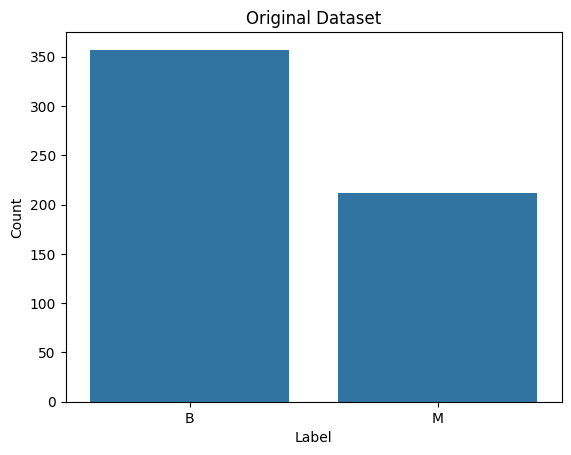

In [152]:
plot_label_distribution(y, 'Original Dataset')

- Phân phối các tập con

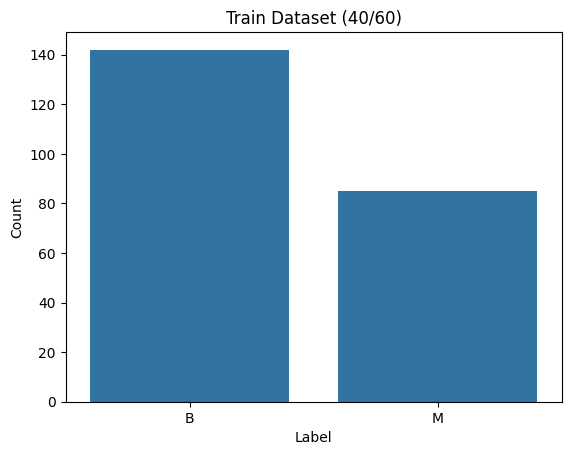

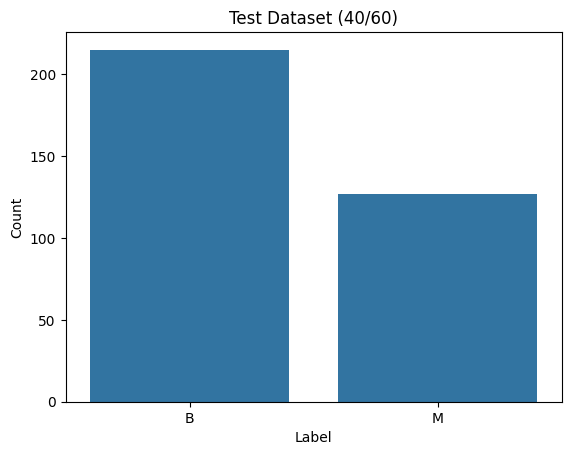

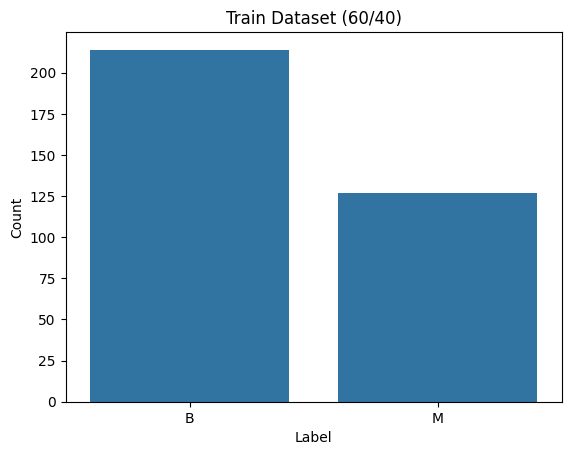

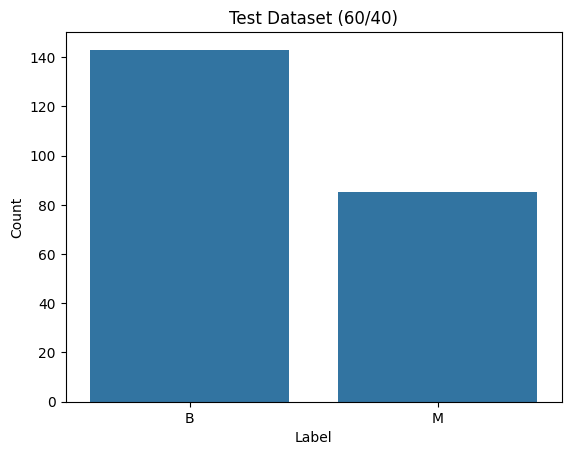

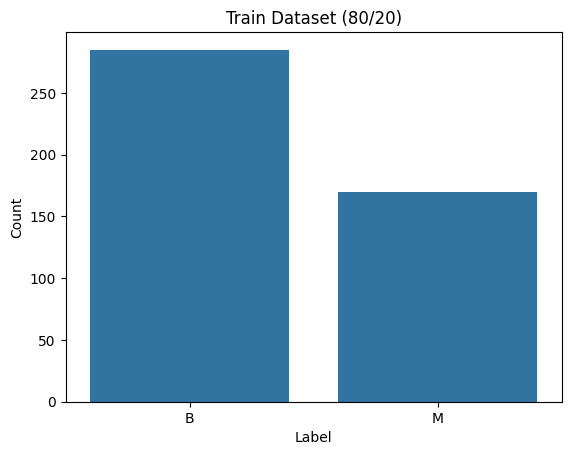

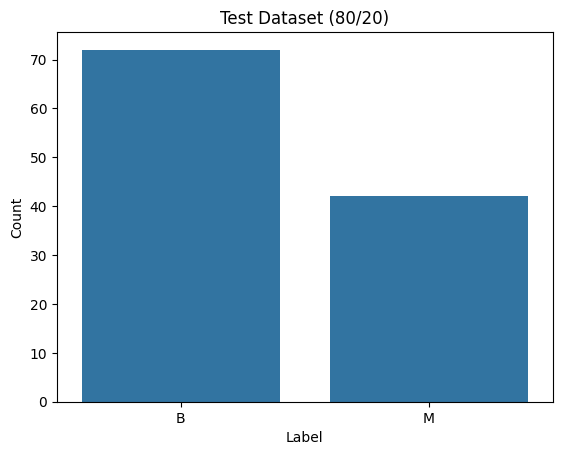

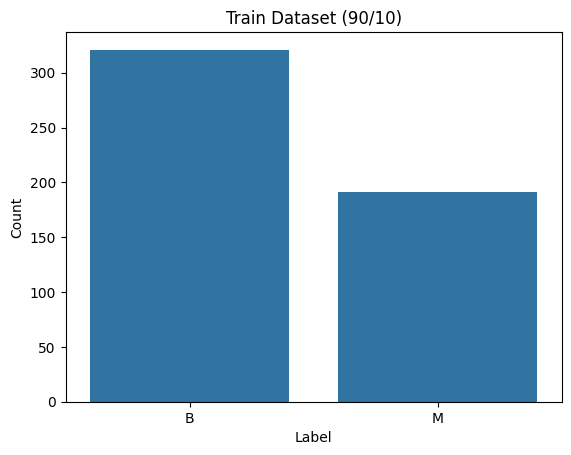

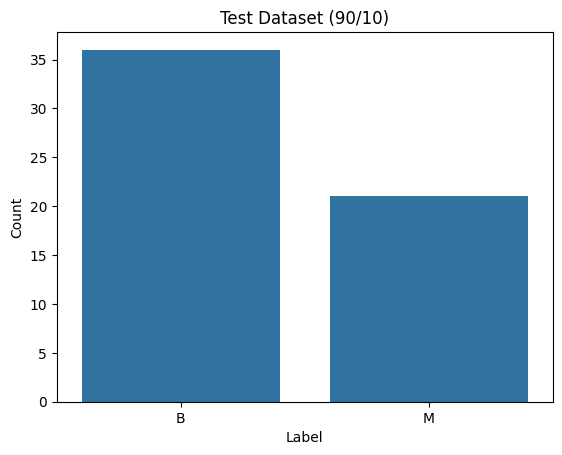

In [153]:
for split_name, dataset in datasets.items():
    plot_label_distribution(dataset['label_train'], f'Train Dataset ({split_name})')
    plot_label_distribution(dataset['label_test'], f'Test Dataset ({split_name})')

## II. Xây dựng bộ phân loạii

In [154]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, accuracy_score
import graphviz

- Hàm huấn luyện và trực quan hóa cây quyết định

In [155]:
dir_path = CONFIG.RESULTS_BASE_TREE_DIR

def train_and_visualize(features_train, labels_train, features_test, labels_test, split_name):
    # Huấn luyện cây quyết định
    model = DecisionTreeClassifier(criterion='entropy', random_state=rand_value)
    model.fit(features_train, labels_train)
    
    # Dự đoán trên tập kiểm tra
    predictions = model.predict(features_test)
    accuracy = accuracy_score(labels_test, predictions)
    
    # Giải mã để xem báo cáo
    labels_test_decoded = encoder.inverse_transform(labels_test)
    predictions_decoded = encoder.inverse_transform(predictions)

    # Dự đoán và đánh giá mô hình
    print(f"Results for split {split_name}")
    print("- Classification Report:")
    print(classification_report(labels_test_decoded, predictions_decoded))

    print(f"- Accuracy: {accuracy:.6f}")
    
    # Trực quan hóa cây quyết định
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=features_train.columns,
        class_names=encoder.classes_,
        filled=True, rounded=True, special_characters=True
    )
    graph = graphviz.Source(dot_data)
    filepath = f"{dir_path}/{split_name.replace('/', '_')}/graph"
    graph.render(filepath, format="pdf")
    # graph.view()  # Mở cây trực tiếp
    # display(graph)
    print(f"- Saved tree visualization for {split_name}")
    print("------------------------------------------\n")

- Huấn luyện và lưu cây cho từng tập con

In [156]:
for split_name, dataset in datasets.items():
    train_and_visualize(
        features_train=dataset['feature_train'],
        labels_train=dataset['label_train'],
        features_test=dataset['feature_test'],
        labels_test=dataset['label_test'],
        split_name=split_name
    )

Results for split 40/60
- Classification Report:
              precision    recall  f1-score   support

           B       0.91      0.96      0.93       215
           M       0.92      0.83      0.88       127

    accuracy                           0.91       342
   macro avg       0.91      0.90      0.90       342
weighted avg       0.91      0.91      0.91       342

- Accuracy: 0.912281
- Saved tree visualization for 40/60
------------------------------------------

Results for split 60/40
- Classification Report:
              precision    recall  f1-score   support

           B       0.94      0.96      0.95       143
           M       0.93      0.91      0.92        85

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228

- Accuracy: 0.938596
- Saved tree visualization for 60/40
------------------------------------------

Results for split 80/20
- Classification Rep

## III. Đánh giá các bộ phân loại

In [157]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

- Hàm đánh giá mô hình và tạo báo cáo

In [158]:
def evaluate_model(features_test, labels_test, model, split_name):
    # Dự đoán trên tập kiểm tra
    predictions = model.predict(features_test)

    # Chuyển ngược về nhãn
    labels_test_decoded = encoder.inverse_transform(labels_test)
    predictions_decoded = encoder.inverse_transform(predictions)
    
    # Classification Report
    print("------------------------------------------\n")
    print(f"- Classification Report for split {split_name}")
    print(classification_report(labels_test_decoded, predictions_decoded))
    # print(classification_report(labels_test, predictions))

    # Confusion Matrix
    cm = confusion_matrix(labels_test, predictions)
    print(f"- Confusion Matrix for split {split_name}:\n{cm}")
    
    # Trực quan hóa ma trận nhầm lẫn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f"Confusion Matrix for {split_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Trả về mô hình và độ chính xác
    accuracy = accuracy_score(labels_test, predictions)
    return accuracy

- Lặp qua từng tập con để huấn luyện, đánh giá, và lưu kết quả

------------------------------------------

- Classification Report for split 40/60
              precision    recall  f1-score   support

           B       0.91      0.96      0.93       215
           M       0.92      0.83      0.88       127

    accuracy                           0.91       342
   macro avg       0.91      0.90      0.90       342
weighted avg       0.91      0.91      0.91       342

- Confusion Matrix for split 40/60:
[[206   9]
 [ 21 106]]


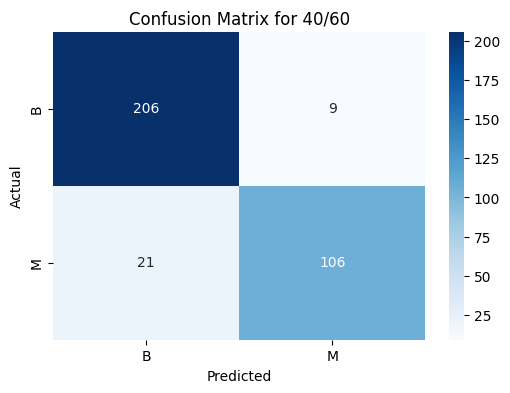

------------------------------------------

- Classification Report for split 60/40
              precision    recall  f1-score   support

           B       0.94      0.96      0.95       143
           M       0.93      0.91      0.92        85

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228

- Confusion Matrix for split 60/40:
[[137   6]
 [  8  77]]


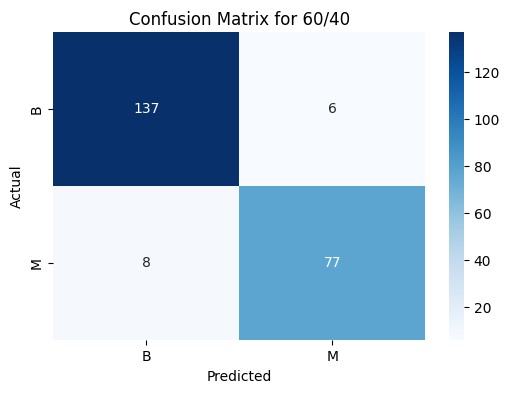

------------------------------------------

- Classification Report for split 80/20
              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

- Confusion Matrix for split 80/20:
[[71  1]
 [ 4 38]]


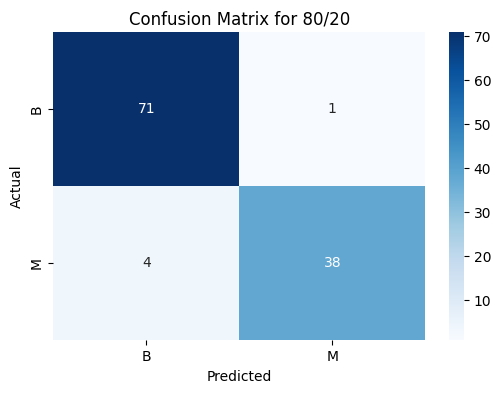

------------------------------------------

- Classification Report for split 90/10
              precision    recall  f1-score   support

           B       0.95      0.97      0.96        36
           M       0.95      0.90      0.93        21

    accuracy                           0.95        57
   macro avg       0.95      0.94      0.94        57
weighted avg       0.95      0.95      0.95        57

- Confusion Matrix for split 90/10:
[[35  1]
 [ 2 19]]


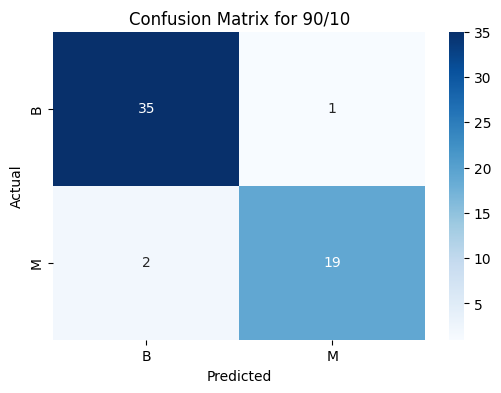

In [159]:
results = {}
for split_name, dataset in datasets.items():
    # Huấn luyện mô hình
    model = DecisionTreeClassifier(criterion='entropy', random_state=rand_value)
    model.fit(dataset['feature_train'], dataset['label_train'])
    
    # Đánh giá mô hình
    accuracy = evaluate_model(
        features_test=dataset['feature_test'],
        labels_test=dataset['label_test'],
        model=model,
        split_name=split_name
    )
    
    # Lưu kết quả
    results[split_name] = accuracy

- Hiển thị tổng hợp kết quả độ chính xác

In [160]:
for split_name, accuracy in results.items():
    print(f"Accuracy for {split_name}: {accuracy:.6f}")

Accuracy for 40/60: 0.912281
Accuracy for 60/40: 0.938596
Accuracy for 80/20: 0.956140
Accuracy for 90/10: 0.947368


## IV Độ sâu và độ chính xác

- Lấy bộ dữ liệu huấn luyện và kiểm tra 80/20

In [161]:
default_split = CONFIG.DEFAULT_SPLIT

X_train = datasets[default_split]['feature_train']
y_train = datasets[default_split]['label_train']
X_test  = datasets[default_split]['feature_test']
y_test  = datasets[default_split]['label_test']

- Thử nghiệm với các giá trị max_depth khác nhau

In [162]:
accuracy_scores = {}
max_depth_values = CONFIG.MAX_DEPTH_VALUES
dir_path = CONFIG.RESULTS_TREE_MAX_DEPTH_DIR

for max_depth in max_depth_values:
    # Tạo và huấn luyện cây quyết định với max_depth
    model = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=rand_value)
    model.fit(X_train, y_train)
    
    # Dự đoán và tính độ chính xác
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores[max_depth] = accuracy
    
    # Trực quan hóa cây quyết định
    print(f"Decision Tree with max_depth={max_depth}")
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=X_train.columns,
        class_names=encoder.classes_,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    path = f"{dir_path}/max_depth_{'None' if max_depth is None else max_depth}/graph"
    graph.render(path, format="pdf")
    print(f"- Saved tree visualization for {path}.pdf")
    print("------------------------------------------\n")


Decision Tree with max_depth=None
- Saved tree visualization for Results/Tree Max Depth/max_depth_None/graph.pdf
------------------------------------------

Decision Tree with max_depth=2
- Saved tree visualization for Results/Tree Max Depth/max_depth_2/graph.pdf
------------------------------------------

Decision Tree with max_depth=3
- Saved tree visualization for Results/Tree Max Depth/max_depth_3/graph.pdf
------------------------------------------

Decision Tree with max_depth=4
- Saved tree visualization for Results/Tree Max Depth/max_depth_4/graph.pdf
------------------------------------------

Decision Tree with max_depth=5
- Saved tree visualization for Results/Tree Max Depth/max_depth_5/graph.pdf
------------------------------------------

Decision Tree with max_depth=6
- Saved tree visualization for Results/Tree Max Depth/max_depth_6/graph.pdf
------------------------------------------

Decision Tree with max_depth=7
- Saved tree visualization for Results/Tree Max Depth/max

- Hiển thị bảng kết quả

In [163]:
print("max_depth\tAccuracy")
for max_depth, accuracy in accuracy_scores.items():
    print(f"{'None' if max_depth is None else max_depth}\t\t{accuracy:.6f}")

max_depth	Accuracy
None		0.956140
2		0.885965
3		0.938596
4		0.929825
5		0.956140
6		0.929825
7		0.956140


- Vẽ biểu đồ độ chính xác

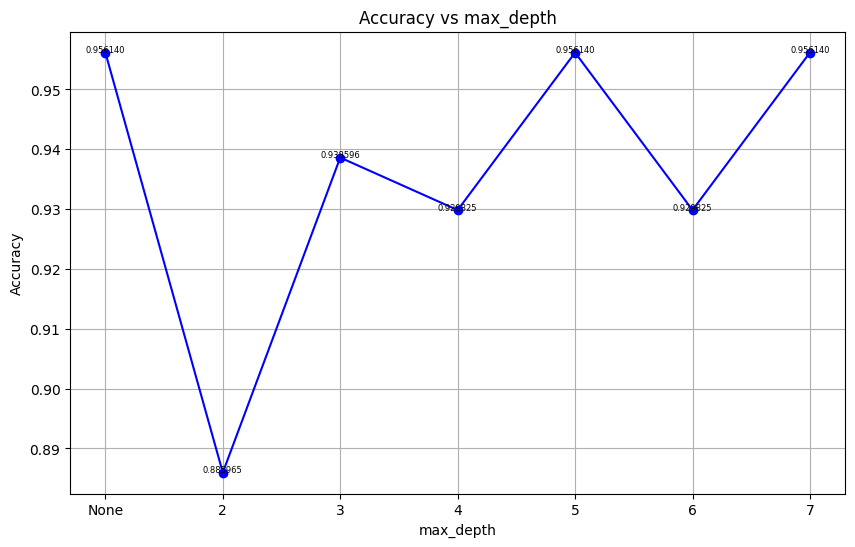

In [164]:
depth_labels = ['None' if d is None else d for d in max_depth_values]
accuracy_values = list(accuracy_scores.values())

plt.figure(figsize=(10, 6))
plt.plot(depth_labels, accuracy_values, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.grid(True)
for i, txt in enumerate(accuracy_values):
    plt.text(i, accuracy_values[i], f"{accuracy_values[i]:.6f}", fontsize=6, ha='center')

plt.show()
